# Radio Images
Transmitting images over radio



In [11]:
%pylab
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import Queue
import threading,time
import sys

from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from numpy import ones
from scipy import signal
from scipy import integrate
from __future__ import division

import threading,time
import multiprocessing

from rtlsdr import RtlSdr
from numpy import mean
from numpy import power
from numpy.fft import fft
from numpy.fft import fftshift
from numpy.fft import ifft
from numpy.fft import ifftshift
import bitarray
from  scipy.io.wavfile import read as wavread
import serial

%matplotlib inline

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [12]:
# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60) :
    eps = 1e-3
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( abs( y ) / y_max + eps )
    
    fig=figure(figsize=(15,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

def play_audio( Q, p, fs , dev, ser="", keydelay=0.200):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    # ser - pyserial device to key the radio
    # keydelay - delay after keying the radio
    
    # Example:
    # fs = 44100
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # Q = Queue.queue()
    # Q.put(data)
    # Q.put("EOT") # when function gets EOT it will quit
    # play_audio( Q, p, fs,1 ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True) #output_device_index=dev)
    # play audio
    while (1):
        data = Q.get()
        if data=="EOT"  :
            break
        elif (data=="KEYOFF"  and ser!=""):
            time.sleep(keydelay)
            ser.setDTR(0)
            #print("keyoff\n")
        elif (data=="KEYON" and ser!=""):
            ser.setDTR(1)  # key PTT
            #print("keyon\n")
            time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
            
        else:
            try:
                ostream.write( data.astype(np.float32).tostring() )
            except:
                print("Exception")
                break
            
def record_audio( queue, p, fs ,dev,chunk=1024):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number 
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) # 
    # p.terminate() # terminate pyAudio
    
   
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        try:  # when the pyaudio object is distroyed stops
            data_str = istream.read(chunk) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list

def text2Morse(text,fc,fs,dt):
    CODE = {'A': '.-',     'B': '-...',   'C': '-.-.', 
        'D': '-..',    'E': '.',      'F': '..-.',
        'G': '--.',    'H': '....',   'I': '..',
        'J': '.---',   'K': '-.-',    'L': '.-..',
        'M': '--',     'N': '-.',     'O': '---',
        'P': '.--.',   'Q': '--.-',   'R': '.-.',
     	'S': '...',    'T': '-',      'U': '..-',
        'V': '...-',   'W': '.--',    'X': '-..-',
        'Y': '-.--',   'Z': '--..',
        
        '0': '-----',  '1': '.----',  '2': '..---',
        '3': '...--',  '4': '....-',  '5': '.....',
        '6': '-....',  '7': '--...',  '8': '---..',
        '9': '----.',

        ' ': ' ', "'": '.----.', '(': '-.--.-',  ')': '-.--.-',
        ',': '--..--', '-': '-....-', '.': '.-.-.-',
        '/': '-..-.',   ':': '---...', ';': '-.-.-.',
        '?': '..--..', '_': '..--.-'
        }
    
    Ndot= 1.0*fs*dt
    Ndah = 3*Ndot
    
    sdot = sin(2*pi*fc*r_[0.0:Ndot]/fs)
    sdah = sin(2*pi*fc*r_[0.0:Ndah]/fs)
    
    # convert to dit dah
    mrs = ""
    for char in text:
        mrs = mrs + CODE[char.upper()] + "*"
    
    sig = zeros(1)
    for char in mrs:
        if char == " ":
            sig = concatenate((sig,zeros(Ndot*7)))
        if char == "*":
            sig = concatenate((sig,zeros(Ndot*3)))
        if char == ".":
            sig = concatenate((sig,sdot,zeros(Ndot)))
        if char == "-":
            sig = concatenate((sig,sdah,zeros(Ndot)))
    return sig
            

def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name
        


In [13]:
def play_audio_direct( data, p, fs):
    # data - audio data array
    # p    - pyAudio object
    # fs    - sampling rate
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=fs,output=True)
    # play audio
    ostream.write( data.astype(np.float32).tostring() )

Copy and paste your afsk1200 and nc_afskDemod functions here:

In [14]:
# copy and paste your own functions here. 

def afsk1200(bits):
    #the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at 44100Hz
    fs = 44100*4
    baud = 1200
    fc = 1700
    delf = 500
    
    bits = np.array(bits.tolist())
    
    #print bits < 1
    
    bits = bits.astype(int)
    
    np.place(bits, bits < 1, [-1])
    
    #print bits
    
    #width, height = figaspect(0.2)
    #fig = figure(figsize=(width,height))

    #plot(np.r_[0:bits.size], bits)

    #your code here
    sperb = fs/baud
    
    t = np.r_[0:bits.size*sperb]
    integ = integrate.cumtrapz(np.repeat(bits, sperb), initial=0)
    
    #fig = figure(figsize=(width,height))
    #plot(np.r_[0:integ.size], integ)
    
    ph = t*2*pi*fc/fs + integ*2*pi*delf/fs
    
    sig = real(exp(1j*ph[::4]))
    
    return sig
        
              


def nc_afskDemod(sig, TBW=2.0, N=74):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZI (without rectifying it)
    
    # your code here
    
    # Generate filters
    
    fs = 44100
    TBW = 2
    N = 147
    BW = 1200/fs
    lowpass = signal.firwin(N, BW)
    t = np.r_[0:N]
    h_space = exp(1j*t*2*pi*2200/fs)*lowpass
    h_mark = exp(1j*t*2*pi*1200/fs)*lowpass
    
    sig_space = signal.fftconvolve(sig, h_space)
    sig_mark = signal.fftconvolve(sig, h_mark)
    
    #NRZI = np.absolute(sig_mark) - np.absolute(sig_space)
    
    #return NRZI > -0.02
   
    mark = np.absolute(sig_mark)
    space = np.absolute(sig_space)

    NRZI = (mark-space)
    return NRZI



In [15]:
# copy and paste your own functions here. 
def afsk1200(bits):
    #the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at 44100Hz
    fs = 44100*4
    fc = 1700
    delta_f = 500
    
    baud = 1200    
    
    samples_bit = fs / baud
    
    m = np.repeat(bits.tolist(), samples_bit)
    m = 2 *(1 - m) - 1
    
    t = arange(len(m))/float(fs)
    
    ii = integrate.cumtrapz(m, dx=1.0/fs, initial=0)

    ph = 2*pi*fc*t + 2*pi*delta_f*ii
    
    sig = np.cos(ph)[::4]
    
    return sig
            

def nc_afskDemod(sig, TBW=2.0, N=74):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZI (without rectifying it)
    
    fs = 44100.0
    BW =  float(TBW) / N
    
    h_mark = signal.firwin(numtaps=N, cutoff=BW) * np.exp(1j * 2 * pi * 1200/fs * arange(N))
    h_space = signal.firwin(numtaps=N, cutoff=BW) * np.exp(1j * 2 * pi * 2200/fs * arange(N))

    v_space = signal.fftconvolve(sig, h_space)
    v_mark  = signal.fftconvolve(sig, h_mark)

    NRZa = abs(v_mark) - abs(v_space)

    return NRZa[N/2:-N/2]


Now, similarly to before, find the audio interface numbers. And intitialize the variables:
dusb_in, dusb_out, din, dout 



In [16]:
        
p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

0 HDA NVidia: CS4206 Analog (hw:0,0)
1 HDA NVidia: CS4206 Digital (hw:0,1)
2 HDA NVidia: HDMI 0 (hw:0,3)
3 HDA NVidia: HDMI 0 (hw:0,7)
4 HDA NVidia: HDMI 0 (hw:0,8)
5 USB PnP Sound Device: Audio (hw:1,0)
6 sysdefault
7 iec958
8 spdif
9 hdmi
10 pulse
11 default


In [17]:
# CHANGE!!!!
dusb_in = 5
dusb_out = 5
din = 0
dout = 0

In [18]:
s = ""

Initialize serial port

In [19]:
if sys.platform == 'darwin':  # Mac
    s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
elif sys.platform == 'linux2':
    s = serial.Serial(port='/dev/ttyUSB1')
else:                         #windows
    s = serial.Serial(port='COM7') 
    
s.setDTR(0)

In [20]:
import ax25

callsign = "KK6STK"
Digi =b'WIDE1-1,WIDE2-1'
dest = "APDSP"

# Uncomment to Send Email
# info = ":EMAIL    :pierre@berkeley.edu What a great lab!"

# Uncomment to Send an SMS message to a phone number (update the number!)
info = ":SMSGTE   :@5106128494 This is a text message from my radio"

#uncomment to show yourself on mt everest
#info = "=2759.16N/08655.30E[I'm on the top of the world"

#uncomment to send to everyone on the APRS system near you
#info = ":ALL      : CQCQCQ I would like to talk to you!"


# uncomment to report position
#info = "=3752.50N/12215.43WlIm using a laptop in Cory Hall!"

# uncomment to send a status message
# info = ">I like radios"


packet = ax25.UI(
		destination=dest,
		source=callsign, 
		info=info,
		digipeaters=Digi.split(b','),
        )
print(packet.unparse())

bitarray('011111100100000100000101000100010110010100000101000000100000011001101001011010010011011001100101000101010110100100000110011101010100100100010001010100010100011000000010010001100111010101001001000100010101000100100110000000101100011011000000000011110101110011001010101100101100101011100010001010101010001000000100000001000000010001011100000000101010110010001100000011000110110010001100010011000001110000101100100111000010110000000100001010100001011010010110110011100000010010010110110011100000010010000110000001000010111010100110000111100010111000000100101101101010011011001110110011101000011011100110101001100000010001100110010011101111011010110110000001001011011010011110000001000100111010000110001001101001011011110110000100100000011001111110')


In [21]:
def NRZ2NRZI(NRZ):
    NRZI = NRZ.copy() 
    current = True
    for n in range(0,len(NRZ)):
        if NRZ[n] :
            NRZI[n] = current
        else:
            NRZI[n] = not(current)
        current = NRZI[n]
    return NRZI


In [22]:
# construct message
bitarray.bitarray()

# bits= bitarray.bitarray(list(np.random.random(1000) > 0.5))
# msg = afsk1200(bits)

msg = afsk1200(NRZ2NRZI(bitarray.bitarray(zeros(160).tolist())+packet.unparse()))


In [23]:
#sdr.close()

In [24]:

t = r_[0:2*44100.0]/44100.0
sig2 = 0.5*sin(2*pi*2000*t)
zero_sample = np.zeros(int(44100 * 0.5))


In [25]:
# create an input output FIFO queues
Qin = Queue.Queue()
Qout = Queue.Queue()


# create a pyaudio object
p = pyaudio.PyAudio()

stop_flag = threading.Event()
# initialize a recording thread. The USB device only supports 44.1KHz sampling rate
t_rec = threading.Thread(target = record_audio,   args = (Qin,   p, 44100, dusb_in, 512))

# initialize a playing thread. 
t_play = threading.Thread(target = play_audio,   args = (Qout,   p, 44100, dout ))

print('starting...')
# start the recording and playing threads
print('recording...')
t_rec.start()

Qout.put(sig2)
Qout.put(zero_sample)
# Qout.put("KEYON")
Qout.put(msg)
# Qout.put("KEYOFF")
Qout.put("EOT")

# play audio from Queue 
t_play.start()

while not(Qout.empty()) :
    time.sleep(1)
    

# kill the pyaudio device. The thread will have an exception and will quit. 
stop_flag.set()
p.terminate()


starting...
recording...


In [26]:
ss = np.array([])
while not Qin.empty():
    ss = np.append(ss, Qin.get())

In [27]:
# function to generate a checksum for validating packets
def genfcs(bits):
    # Generates a checksum from packet bits
    fcs = ax25.FCS()
    for bit in bits:
        fcs.update_bit(bit)
    
    digest = bitarray.bitarray(endian="little")
    digest.frombytes(fcs.digest())

    return digest


# function to parse packet bits to information
def decodeAX25(bits):
    ax = ax25.AX25()
    ax.info = "bad packet"
    
    
    bitsu = ax25.bit_unstuff(bits[8:-8])
    
    if (genfcs(bitsu[:-16]).tobytes() == bitsu[-16:].tobytes()) == False:
        #print("failed fcs")
        return ax
    
    bytes = bitsu.tobytes()
    ax.destination = ax.callsign_decode(bitsu[:56])
    source = ax.callsign_decode(bitsu[56:112])
    if source[-1].isdigit() and source[-1]!="0":
        ax.source = b"".join((source[:-1],'-',source[-1]))
    else:
        ax.source = source[:-1]
    
    digilen=0    
    
    if bytes[14]=='\x03' and bytes[15]=='\xf0':
        digilen = 0
    else:
        for n in range(14,len(bytes)-1):
            if ord(bytes[n]) & 1:
                digilen = (n-14)+1
                break

#    if digilen > 56:
#        return ax
    ax.digipeaters =  ax.callsign_decode(bitsu[112:112+digilen*8])
    ax.info = bitsu[112+digilen*8+16:-16].tobytes()
    
    return ax


def detectFrames(NRZI):  
    # function looks for packets in an NRZI sequence and validates their checksum
    
    # compute finite differences of the digital NRZI to detect zero-crossings
    dNRZI = NRZI[1:] - NRZI[:-1]
    # find the position of the non-zero components. These are the indexes of the zero-crossings. 
    transit = nonzero(dNRZI)[0]
    # Transition time is the difference between zero-crossings
    transTime = transit[1:]-transit[:-1]
    
    # loop over transitions, convert to bit streams and extract packets
    dict = { 1:bitarray.bitarray([0]), 2:bitarray.bitarray([1,0]), 3:bitarray.bitarray([1,1,0]),
            4:bitarray.bitarray([1,1,1,0]),5:bitarray.bitarray([1,1,1,1,0]),6:bitarray.bitarray([1,1,1,1,1,0])
            ,7:bitarray.bitarray([1,1,1,1,1,1,0])}
    
    state = 0; # no flag detected yet
    
    packets =[]
    tmppkt = bitarray.bitarray([0])
    lastFlag = 0  # position of the last flag found. 
    
    for n in range(0,len(transTime)):
        Nb = round(transTime[n]/36.75)  # maps intervals to bits. Assume 44100Hz and 1200baud
        if (Nb == 7 and state ==0):
            # detected flag frame, start collecting a packet
            tmppkt = tmppkt +  dict[7]
            state = 1  # packet detected
            lastFlag = transit[n-1]
            continue
        if (Nb == 7 and state == 1):
            # detected end frame successfully
            tmppkt = tmppkt + dict[7]
            
            # validate checksum
            bitsu = ax25.bit_unstuff(tmppkt[8:-8]) # unstuff bits
            if (genfcs(bitsu[:-16]).tobytes() == bitsu[-16:].tobytes()) :
                # valid packet
                packets.append(tmppkt)                
            tmppkt  = bitarray.bitarray([0])
            state = 0
            continue
        
        if (state == 1 and Nb < 7 and Nb > 0):
            # valid bits 
            tmppkt = tmppkt + dict[Nb]
            continue
        else:
            # not valid bits reset
            state = 0
            tmppkt  = bitarray.bitarray([0])
            continue
   
    if state == 0:
        lastFlag = -1
    
    # if the state is 1, which means that we detected a packet, but the buffer ended, then
    # we return the position of the beginning of the flag within the buffer to let the caller
    # know that there's a packet that overlapps between two buffer frames. 
    
    return packets, lastFlag
            
    


In [28]:
fs = 44100.0

1


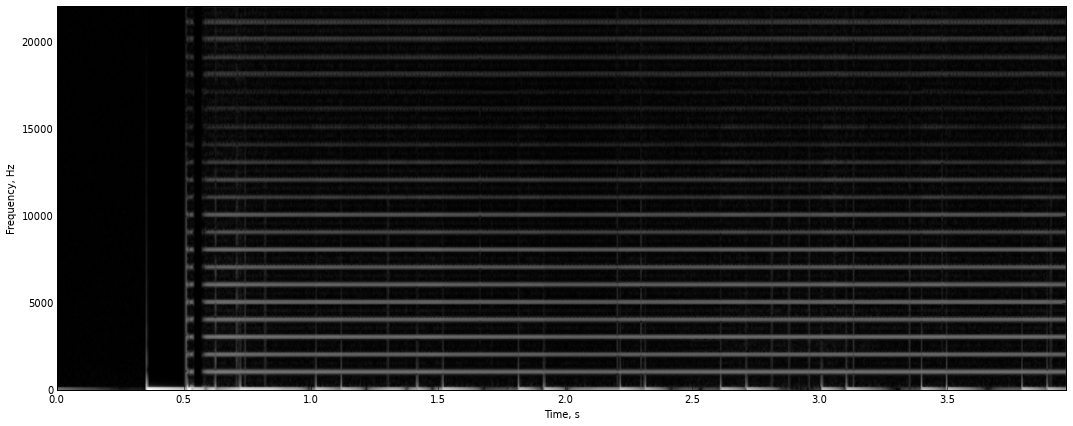

In [29]:
_ = myspectrogram_hann_ovlp(ss, 512, fs, 0)

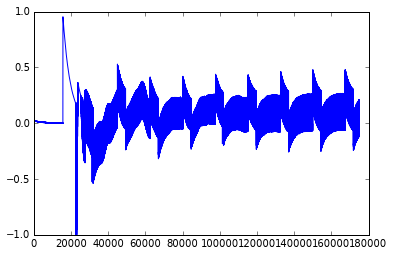

In [30]:
plot(ss)

In [31]:
sig = ss

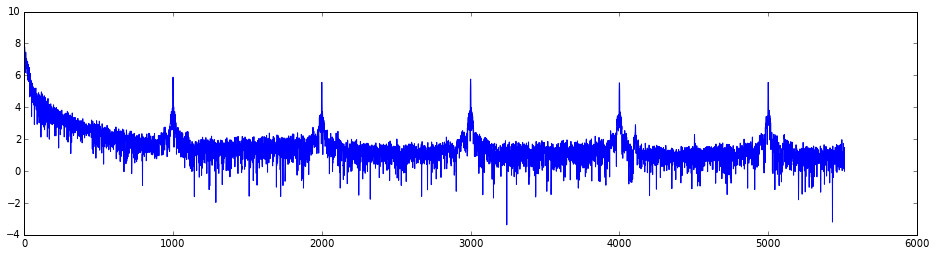

In [32]:
fig = figure(figsize(16,4))
plot(linspace(0,22050/4,20000/4),np.log(abs(np.fft.fft(sig,n=40000)))[:20000/4])

In [33]:
NRZIa = nc_afskDemod(sig)
NRZI = sign(NRZIa)
packets ,lastflag = detectFrames(NRZI)

for pkt in packets:
        ax = decodeAX25(pkt)
        print(ax.destination ,ax.source ,ax.digipeaters,ax.info)
